# Notebook Description
This notebook includes experiments of using 1d-CNN on the text of the pairs, with shared weights (siamese network). It explores different kinds of loss function.

# Setup

In [ ]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt

# Set options and load file
pd.set_option('display.float_format', lambda x: '%.3f' % x)

%load_ext google.colab.data_table
from google.colab import data_table
from google.colab import drive

drive.mount('/content/drive')
os.chdir("YOUR FOLDER HERE")
raw_data_folder = './data/raw/'
interim_data_folder = './data/interim/'
processed_data_folder = './data/processed/'
models_folder = './models/'

Mounted at /content/drive


In [ ]:
import keras
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Input
from keras.models import Model
from tensorflow.keras.layers import Dot, LSTM, Bidirectional, Reshape,Flatten
from keras.layers.core import Dense
from keras import backend as K
from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding, Conv1D

!pip install keras_nlp
from keras_nlp.layers import PositionEmbedding


from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 151 kB 12.6 MB/s 
     |████████████████████████████████| 5.9 MB 8.9 MB/s 
     |████████████████████████████████| 578.0 MB 16 kB/s 
INFO: pip is looking at multiple versions of tensorflow-text to determine which version is compatible with other requirements. This could take a while.
     |████████████████████████████████| 4.6 MB 39.2 MB/s 


# Load Data

In [ ]:
# Load Data
# -------------
alphabet = 'eainlrsotdychmbugkjpfvzwxq.ó'
print('Alphabet:')
print(alphabet)

# Original dfs
train_df = pd.read_csv(interim_data_folder + 'train_df_mixed_shuffled.csv', index_col=0)
validation_df = pd.read_csv(interim_data_folder + 'validation_df_mixed_shuffled.csv', index_col=0)
test_df = pd.read_csv(interim_data_folder + 'test_df_mixed_shuffled.csv', index_col=0)

# tokenized dfs
train_data_names = np.loadtxt(processed_data_folder + 'train_mixed_data_names.txt', dtype = int)
train_data_nicknames = np.loadtxt(processed_data_folder + 'train_mixed_data_nicknames.txt', dtype = int)
validation_data_names = np.loadtxt(processed_data_folder + 'validation_mixed_data_names.txt', dtype = int)
validation_data_nicknames = np.loadtxt(processed_data_folder + 'validation_mixed_data_nicknames.txt', dtype = int)
test_data_names = np.loadtxt(processed_data_folder + 'test_mixed_data_names.txt', dtype = int)
test_data_nicknames = np.loadtxt(processed_data_folder + 'test_mixed_data_nicknames.txt', dtype = int)

# targets
train_targets = np.loadtxt(processed_data_folder + 'train_mixed_targets.txt', dtype = int)
validation_targets = np.loadtxt(processed_data_folder + 'validation_mixed_targets.txt', dtype = int)
test_targets = np.loadtxt(processed_data_folder + 'test_mixed_targets.txt', dtype = int)

print(train_df['name'].tolist()[1])

train_df.iloc[:5]

Alphabet:
eainlrsotdychmbugkjpfvzwxq.ó
flora


,name,nickname,y
4918,theodore,cy,0
4225,flora,belle,0
6871,isabella,bel,1
1136,jo,ara,0
1754,clement,jessie,0


In [ ]:
# print((train_df['y'].values == train_targets))
print(train_df.iloc[:5])
print(train_data_names[:5],'\n')
print(train_data_nicknames[:5])


          name nickname  y
4918  theodore       cy  0
4225     flora    belle  0
6871  isabella      bel  1
1136        jo      ara  0
1754   clement   jessie  0
[[ 9 13  1  8 10  8  6  1  0  0  0  0  0  0  0]
 [21  5  8  6  2  0  0  0  0  0  0  0  0  0  0]
 [ 3  7  2 15  1  5  5  2  0  0  0  0  0  0  0]
 [19  8  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [12  5  1 14  1  4  9  0  0  0  0  0  0  0  0]] 

[[12 11  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [15  1  5  5  1  0  0  0  0  0  0  0  0  0  0]
 [15  1  5  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  6  2  0  0  0  0  0  0  0  0  0  0  0  0]
 [19  1  7  7  3  1  0  0  0  0  0  0  0  0  0]]


In [ ]:
# Define Loss
def cosine_loss(y_true, y_pred, m=0.4, alpha = 0.25):
  # IT IS IMPORTANT TO NOTE THAT IN KERAS CUSTOM LOSS FUNCTIONS, THE ORDER
  # DOES MATTER - KERAS ASSUMES THAT THE FIRST ELEMENT IS y AND THAT THE SECOND
  # IS y_hat.

  y_true=tf.cast(y_true, tf.float32)
  y_pred=tf.cast(y_pred, tf.float32)

  # Create the mask - wherever y_pred<m. Recall that this condition takes place 
  # only for L_ and if E>=m then L_==0. 
  # mask = K.less(y_pred,m)
  mask = K.greater(y_pred,m)
  
  mask = tf.cast(mask,tf.float32)
  mask = mask * (1-y_true)*K.square(y_pred)
  # print(mask)
  L = y_true*alpha*tf.square(1 - y_pred) + mask
  return K.mean(L)



# BCE Loss

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 15, 1)]      0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 15, 1)]      0           []                               
                                                                                                  
 model (Functional)             (None, 15, 1, 1)     16138       ['input_2[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 dot (Dot)                      (None, 1, 1, 1, 1)   0           ['model[0][0]',            

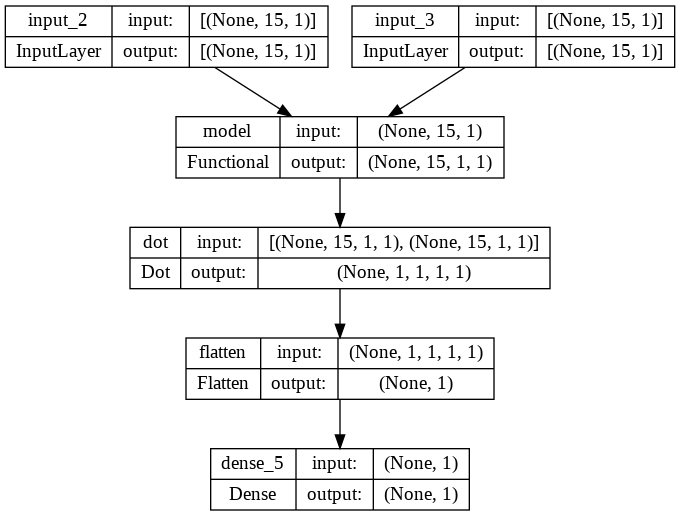

In [ ]:
tf.random.set_seed(
    2
)


# define model
input = Input((15,1))
embedded = Embedding(15,35)(input)
position_embeddings = PositionEmbedding(sequence_length=15)(embedded)
embedded = embedded + position_embeddings
cnn = tf.keras.layers.Conv1D(filters = 32,
                            kernel_size = 2,
                            padding = 'same',
                            activation = 'relu')(embedded)

cnn = Dense(35)(cnn)
cnn = embedded + cnn

cnn = tf.keras.layers.Conv1D(filters = 16,
                            kernel_size = 4,
                            padding = 'same',
                            activation = 'sigmoid')(cnn)

cnn = Dense(35)(cnn)
cnn = embedded + cnn

cnn = tf.keras.layers.Conv1D(filters = 16,
                            kernel_size = 8,
                            padding = 'same',
                            activation = 'sigmoid')(cnn)

cnn = Dense(35)(cnn)
cnn = embedded + cnn

cnn = tf.keras.layers.Conv1D(filters = 8,
                            kernel_size = 12,
                            padding = 'same',
                            activation = 'sigmoid')(cnn)

cnn = Dense(35)(cnn)
cnn = embedded + cnn

output = Dense(1)(cnn)

cnn_model = Model(input,output)

# define towers
input_1 = Input((15,1))
input_2 = Input((15,1))

tower_1 = cnn_model(input_1)
tower_2 = cnn_model(input_2)

merged = Dot(axes=(1), normalize=True)([tower_1, tower_2])
merged = Flatten()(merged)
y_pred = Dense(1, activation="sigmoid")(merged)

# define optimizer
opt = keras.optimizers.Adam(learning_rate=0.05)

siamese_net = Model(inputs=[input_1,input_2],outputs=y_pred)
siamese_net.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=opt)
# siamese_net.compile(loss=cosine_loss, optimizer=opt)


print(siamese_net.summary())
tf.keras.utils.plot_model(siamese_net, show_shapes=True)

## Training

In [ ]:
from tensorflow.keras.callbacks import (ModelCheckpoint, TensorBoard, ReduceLROnPlateau,
                                        CSVLogger, EarlyStopping)
from tensorflow.keras.optimizers import Adam


# checkpointer
keras_callbacks   = [
      EarlyStopping(monitor='val_loss', patience=75, mode='min'),
      ReduceLROnPlateau(monitor='val_loss', factor=0.9,
                              patience=20, min_lr=0.001),
      ModelCheckpoint(filepath=models_folder + 'mixed_val_loss_shared_weights_CNN.hdf5', 
                      monitor='val_loss',
                      verbose=1, 
                      save_best_only=True, 
                      mode='min',
                      restore_best_weights=True)
]

hist = siamese_net.fit(x = [train_data_names, train_data_nicknames],
                     y = train_targets,
                       validation_data=([validation_data_names, validation_data_nicknames], 
                                        validation_targets),
                       epochs = 100,
                       verbose = 1,
                       shuffle = True,
                       batch_size = 16,
                       callbacks=[keras_callbacks])

Epoch 1/100
472/472 [==============================] - ETA: 0s - loss: 0.5044
Epoch 1: val_loss improved from inf to 0.50710, saving model to ./models/mixed_val_loss_shared_weights_CNN.hdf5
472/472 [==============================] - 27s 29ms/step - loss: 0.5044 - val_loss: 0.5071 - lr: 0.0500
Epoch 2/100
471/472 [============================>.] - ETA: 0s - loss: 0.5029
Epoch 2: val_loss improved from 0.50710 to 0.50069, saving model to ./models/mixed_val_loss_shared_weights_CNN.hdf5
472/472 [==============================] - 11s 23ms/step - loss: 0.5029 - val_loss: 0.5007 - lr: 0.0500
Epoch 3/100
472/472 [==============================] - ETA: 0s - loss: 0.5030
Epoch 3: val_loss did not improve from 0.50069
472/472 [==============================] - 6s 12ms/step - loss: 0.5030 - val_loss: 0.5009 - lr: 0.0500
Epoch 4/100
470/472 [============================>.] - ETA: 0s - loss: 0.5029
Epoch 4: val_loss did not improve from 0.50069
472/472 [==============================] - 6s 12ms/step

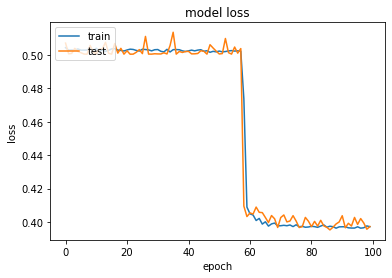

In [ ]:
import matplotlib.pyplot as plt

# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

236/236 [==============================] - 10s 7ms/step
0.8073102823843129


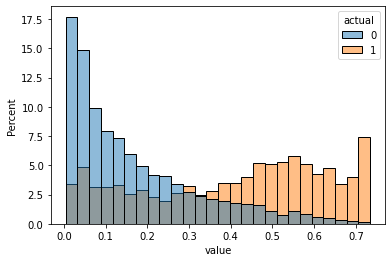

In [ ]:
from keras.models import load_model
import seaborn as sns
from sklearn import metrics

pd.options.display.float_format = '{:.2f}'.format

model = load_model(models_folder + 'mixed_val_loss_shared_weights_CNN.hdf5', custom_objects={'PositionEmbedding': PositionEmbedding})

preds_train = pd.DataFrame(model.predict([train_data_names, train_data_nicknames]), columns = ['value'])
preds_train['actual'] = train_targets

fpr, tpr, thresholds = metrics.roc_curve(preds_train['actual'].values, 
                                         preds_train['value'].values)
print(metrics.auc(fpr, tpr))

sns.histplot(x = 'value', hue = 'actual', data = preds_train, stat="percent", common_norm=False)

45/45 [==============================] - 1s 6ms/step
0.802719570639151


Text(0.5, 1.0, 'BCE Loss, ROC AUC: 0.803')

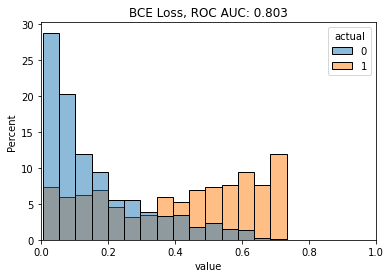

In [ ]:
from keras.models import load_model
import seaborn as sns
from sklearn import metrics

pd.options.display.float_format = '{:.2f}'.format

model = load_model(models_folder + 'mixed_val_loss_shared_weights_CNN.hdf5', custom_objects={'PositionEmbedding': PositionEmbedding})

preds_val = pd.DataFrame(model.predict([validation_data_names, validation_data_nicknames]), columns = ['value'])
preds_val['actual'] = validation_targets

fpr, tpr, thresholds = metrics.roc_curve(preds_val['actual'].values, 
                                         preds_val['value'].values)
print(metrics.auc(fpr, tpr))

sns.histplot(x = 'value', hue = 'actual', data = preds_val, stat="percent", common_norm=False)
plt.xlim(0,1)
plt.title(f'BCE Loss, ROC AUC: {np.round(metrics.auc(fpr, tpr),3)}')


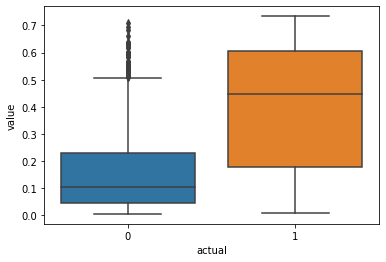

In [ ]:
import seaborn as sns

sns.boxplot(data = preds_val, y='value', x='actual')


# Contrastive Loss

## Dot and then Contrastive loss

In [ ]:
def loss(margin=1):
    """Provides 'constrastive_loss' an enclosing scope with variable 'margin'.

    Arguments:
        margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).

    Returns:
        'constrastive_loss' function with data ('margin') attached.
    """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the constrastive loss.

        Arguments:
            y_true: List of labels, each label is of type float32.
            y_pred: List of predictions of same length as of y_true,
                    each label is of type float32.

        Returns:
            A tensor containing constrastive loss as floating point value.
        """
        y_pred = tf.cast(y_pred, tf.float32)
        y_true = tf.cast(y_true, tf.float32)
        
        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

In [ ]:
tf.random.set_seed(
    2
)


# define model
input = Input((15,1))
embedded = Embedding(15,35)(input)
position_embeddings = PositionEmbedding(sequence_length=15)(embedded)
embedded = embedded + position_embeddings
cnn = tf.keras.layers.Conv1D(filters = 32,
                            kernel_size = 2,
                            padding = 'same',
                            activation = 'relu')(embedded)

cnn = Dense(35)(cnn)
cnn = embedded + cnn

cnn = tf.keras.layers.Conv1D(filters = 16,
                            kernel_size = 4,
                            padding = 'same',
                            activation = 'sigmoid')(cnn)

cnn = Dense(35)(cnn)
cnn = embedded + cnn

cnn = tf.keras.layers.Conv1D(filters = 16,
                            kernel_size = 8,
                            padding = 'same',
                            activation = 'sigmoid')(cnn)

cnn = Dense(35)(cnn)
cnn = embedded + cnn

cnn = tf.keras.layers.Conv1D(filters = 8,
                            kernel_size = 12,
                            padding = 'same',
                            activation = 'sigmoid')(cnn)

cnn = Dense(35)(cnn)
cnn = embedded + cnn

output = Dense(1)(cnn)

cnn_model = Model(input,output)

# define towers
input_1 = Input((15,1))
input_2 = Input((15,1))

tower_1 = cnn_model(input_1)
tower_2 = cnn_model(input_2)

merged = Dot(axes=(1), normalize=True)([tower_1, tower_2])
merged = Flatten()(merged)
y_pred = Dense(1, activation="sigmoid")(merged)

# define optimizer
opt = keras.optimizers.Adam(learning_rate=0.05)

siamese_net = Model(inputs=[input_1,input_2],outputs=y_pred)

In [ ]:
margin = 0.4
siamese_net.compile(loss=loss(margin=margin), optimizer=opt)


In [ ]:
from tensorflow.keras.callbacks import (ModelCheckpoint, TensorBoard, ReduceLROnPlateau,
                                        CSVLogger, EarlyStopping)
from tensorflow.keras.optimizers import Adam


# checkpointer
keras_callbacks   = [
      EarlyStopping(monitor='val_loss', patience=75, mode='min'),
      ReduceLROnPlateau(monitor='val_loss', factor=0.9,
                              patience=20, min_lr=0.001),
      ModelCheckpoint(filepath= models_folder + 'mixed_val_loss_shared_weights_CNN_contrastiveloss.hdf5', 
                      monitor='val_loss',
                      verbose=1, 
                      save_best_only=True, 
                      mode='min',
                      restore_best_weights=True)
]
# with open('./models/BLSTM.json','w') as f:    # save the model
#     f.write(model.to_json()) 

hist = siamese_net.fit(x = [train_data_names, train_data_nicknames],
                     y = train_targets,
                       validation_data=([validation_data_names, validation_data_nicknames], 
                                        validation_targets),
                       epochs = 100,
                       verbose = 1,
                       shuffle = True,
                       batch_size = 16,
                       callbacks=[keras_callbacks])

Epoch 1/100
471/472 [============================>.] - ETA: 0s - loss: 0.0276
Epoch 1: val_loss improved from inf to 0.02563, saving model to ./models/mixed_val_loss_shared_weights_CNN_contrastiveloss.hdf5
472/472 [==============================] - 9s 13ms/step - loss: 0.0276 - val_loss: 0.0256 - lr: 0.0500
Epoch 2/100
468/472 [============================>.] - ETA: 0s - loss: 0.0257
Epoch 2: val_loss improved from 0.02563 to 0.02560, saving model to ./models/mixed_val_loss_shared_weights_CNN_contrastiveloss.hdf5
472/472 [==============================] - 6s 12ms/step - loss: 0.0257 - val_loss: 0.0256 - lr: 0.0500
Epoch 3/100
470/472 [============================>.] - ETA: 0s - loss: 0.0257
Epoch 3: val_loss did not improve from 0.02560
472/472 [==============================] - 5s 12ms/step - loss: 0.0257 - val_loss: 0.0256 - lr: 0.0500
Epoch 4/100
470/472 [============================>.] - ETA: 0s - loss: 0.0257
Epoch 4: val_loss did not improve from 0.02560
472/472 [================

236/236 [==============================] - 2s 6ms/step
0.49397317973460725


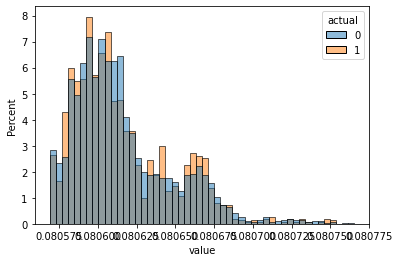

In [ ]:
from keras.models import load_model
import seaborn as sns
from sklearn import metrics

pd.options.display.float_format = '{:.2f}'.format

model = load_model('./models/mixed_val_loss_shared_weights_CNN_contrastiveloss.hdf5', custom_objects={'PositionEmbedding': PositionEmbedding, 'contrastive_loss': loss})

preds_train = pd.DataFrame(model.predict([train_data_names, train_data_nicknames]), columns = ['value'])
preds_train['actual'] = train_targets

fpr, tpr, thresholds = metrics.roc_curve(preds_train['actual'].values, 
                                         preds_train['value'].values)
print(metrics.auc(fpr, tpr))

sns.histplot(x = 'value', hue = 'actual', data = preds_train, stat="percent", common_norm=False)

## With Euclidean distance instead of Dot

### Margin = 0.5

In [ ]:
def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))


In [ ]:
tf.random.set_seed(
    2
)


# define model
input = Input((15,1))
embedded = Embedding(15,35)(input)
position_embeddings = PositionEmbedding(sequence_length=15)(embedded)
embedded = embedded + position_embeddings
cnn = tf.keras.layers.Conv1D(filters = 32,
                            kernel_size = 2,
                            padding = 'same',
                            activation = 'relu')(embedded)

cnn = Dense(35)(cnn)
cnn = embedded + cnn

cnn = tf.keras.layers.Conv1D(filters = 16,
                            kernel_size = 4,
                            padding = 'same',
                            activation = 'sigmoid')(cnn)

cnn = Dense(35)(cnn)
cnn = embedded + cnn

cnn = tf.keras.layers.Conv1D(filters = 16,
                            kernel_size = 8,
                            padding = 'same',
                            activation = 'sigmoid')(cnn)

cnn = Dense(35)(cnn)
cnn = embedded + cnn

cnn = tf.keras.layers.Conv1D(filters = 8,
                            kernel_size = 12,
                            padding = 'same',
                            activation = 'sigmoid')(cnn)

cnn = Dense(35)(cnn)
cnn = embedded + cnn

output = Dense(1)(cnn)

cnn_model = Model(input,output)

# define towers
input_1 = Input((15,1))
input_2 = Input((15,1))

tower_1 = cnn_model(input_1)
tower_2 = cnn_model(input_2)

# merged = Dot(axes=(1), normalize=True)([tower_1, tower_2])
merged = keras.layers.Lambda(euclidean_distance)([tower_1, tower_2])
merged = Flatten()(merged)
y_pred = Dense(1, activation="sigmoid")(merged)

# define optimizer
opt = keras.optimizers.Adam(learning_rate=0.05)

siamese_net = Model(inputs=[input_1,input_2],outputs=y_pred)

In [ ]:
margin = 0.5
siamese_net.compile(loss=loss(margin=margin), optimizer=opt)


In [ ]:
from tensorflow.keras.callbacks import (ModelCheckpoint, TensorBoard, ReduceLROnPlateau,
                                        CSVLogger, EarlyStopping)
from tensorflow.keras.optimizers import Adam


# checkpointer
keras_callbacks   = [
      EarlyStopping(monitor='val_loss', patience=75, mode='min'),
      ReduceLROnPlateau(monitor='val_loss', factor=0.9,
                              patience=20, min_lr=0.001),
      ModelCheckpoint(filepath=models_folder + 'mixed_val_loss_shared_weights_CNN_contrastiveloss_euclidean.hdf5', 
                      monitor='val_loss',
                      verbose=1, 
                      save_best_only=True, 
                      mode='min',
                      restore_best_weights=True)
]
# with open('./models/BLSTM.json','w') as f:    # save the model
#     f.write(model.to_json()) 

hist = siamese_net.fit(x = [train_data_names, train_data_nicknames],
                     y = train_targets,
                       validation_data=([validation_data_names, validation_data_nicknames], 
                                        validation_targets),
                       epochs = 100,
                       verbose = 1,
                       shuffle = True,
                       batch_size = 16,
                       callbacks=[keras_callbacks])

Epoch 1/100
470/472 [============================>.] - ETA: 0s - loss: 0.0359
Epoch 1: val_loss improved from inf to 0.03300, saving model to ./models/mixed_val_loss_shared_weights_CNN_contrastiveloss_euclidean.hdf5
472/472 [==============================] - 9s 13ms/step - loss: 0.0359 - val_loss: 0.0330 - lr: 0.0500
Epoch 2/100
472/472 [==============================] - ETA: 0s - loss: 0.0335
Epoch 2: val_loss did not improve from 0.03300
472/472 [==============================] - 5s 11ms/step - loss: 0.0335 - val_loss: 0.0393 - lr: 0.0500
Epoch 3/100
471/472 [============================>.] - ETA: 0s - loss: 0.0340
Epoch 3: val_loss improved from 0.03300 to 0.03143, saving model to ./models/mixed_val_loss_shared_weights_CNN_contrastiveloss_euclidean.hdf5
472/472 [==============================] - 5s 12ms/step - loss: 0.0339 - val_loss: 0.0314 - lr: 0.0500
Epoch 4/100
472/472 [==============================] - ETA: 0s - loss: 0.0338
Epoch 4: val_loss did not improve from 0.03143
472/4

236/236 [==============================] - 2s 7ms/step
0.7758043529117913


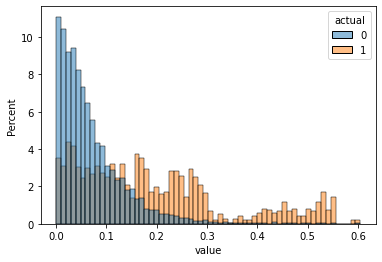

In [ ]:
from keras.models import load_model
import seaborn as sns
from sklearn import metrics

pd.options.display.float_format = '{:.2f}'.format

model = load_model(models_folder + 'mixed_val_loss_shared_weights_CNN_contrastiveloss_euclidean.hdf5', custom_objects={'PositionEmbedding': PositionEmbedding, 'contrastive_loss': loss})

preds_train = pd.DataFrame(model.predict([train_data_names, train_data_nicknames]), columns = ['value'])
preds_train['actual'] = train_targets

fpr, tpr, thresholds = metrics.roc_curve(preds_train['actual'].values, 
                                         preds_train['value'].values)
print(metrics.auc(fpr, tpr))

sns.histplot(x = 'value', hue = 'actual', data = preds_train, stat="percent", common_norm=False)

45/45 [==============================] - 1s 7ms/step
0.7676231111545797


Text(0.5, 1.0, 'Contrastive loss, margin=0.5, ROC AUC: 0.768')

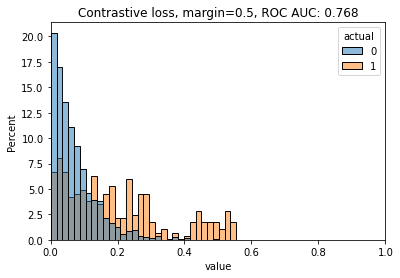

In [ ]:
from keras.models import load_model
import seaborn as sns
from sklearn import metrics

pd.options.display.float_format = '{:.2f}'.format

model = load_model(models_folder + 'mixed_val_loss_shared_weights_CNN_contrastiveloss_euclidean.hdf5', custom_objects={'PositionEmbedding': PositionEmbedding, 'contrastive_loss': loss})

preds_val = pd.DataFrame(model.predict([validation_data_names, validation_data_nicknames]), columns = ['value'])
preds_val['actual'] = validation_targets

fpr, tpr, thresholds = metrics.roc_curve(preds_val['actual'].values, 
                                         preds_val['value'].values)
print(metrics.auc(fpr, tpr))

sns.histplot(x = 'value', hue = 'actual', data = preds_val, stat="percent", common_norm=False)
plt.xlim(0,1)
plt.title(f'Contrastive loss, margin=0.5, ROC AUC: {np.round(metrics.auc(fpr, tpr),3)}')


### Margin = 1

In [ ]:
tf.random.set_seed(
    2
)


# define model
input = Input((15,1))
embedded = Embedding(15,35)(input)
position_embeddings = PositionEmbedding(sequence_length=15)(embedded)
embedded = embedded + position_embeddings
cnn = tf.keras.layers.Conv1D(filters = 32,
                            kernel_size = 2,
                            padding = 'same',
                            activation = 'relu')(embedded)

cnn = Dense(35)(cnn)
cnn = embedded + cnn

cnn = tf.keras.layers.Conv1D(filters = 16,
                            kernel_size = 4,
                            padding = 'same',
                            activation = 'sigmoid')(cnn)

cnn = Dense(35)(cnn)
cnn = embedded + cnn

cnn = tf.keras.layers.Conv1D(filters = 16,
                            kernel_size = 8,
                            padding = 'same',
                            activation = 'sigmoid')(cnn)

cnn = Dense(35)(cnn)
cnn = embedded + cnn

cnn = tf.keras.layers.Conv1D(filters = 8,
                            kernel_size = 12,
                            padding = 'same',
                            activation = 'sigmoid')(cnn)

cnn = Dense(35)(cnn)
cnn = embedded + cnn

output = Dense(1)(cnn)

cnn_model = Model(input,output)

# define towers
input_1 = Input((15,1))
input_2 = Input((15,1))

tower_1 = cnn_model(input_1)
tower_2 = cnn_model(input_2)

# merged = Dot(axes=(1), normalize=True)([tower_1, tower_2])
merged = keras.layers.Lambda(euclidean_distance)([tower_1, tower_2])
merged = Flatten()(merged)
y_pred = Dense(1, activation="sigmoid")(merged)

# define optimizer
opt = keras.optimizers.Adam(learning_rate=0.05)

siamese_net = Model(inputs=[input_1,input_2],outputs=y_pred)

margin = 1
siamese_net.compile(loss=loss(margin=margin), optimizer=opt)



In [ ]:
from tensorflow.keras.callbacks import (ModelCheckpoint, TensorBoard, ReduceLROnPlateau,
                                        CSVLogger, EarlyStopping)
from tensorflow.keras.optimizers import Adam


# checkpointer
keras_callbacks   = [
      EarlyStopping(monitor='val_loss', patience=75, mode='min'),
      ReduceLROnPlateau(monitor='val_loss', factor=0.9,
                              patience=20, min_lr=0.001),
      ModelCheckpoint(filepath=models_folder + 'mixed_val_loss_shared_weights_CNN_contrastiveloss_euclidean_margin1.hdf5', 
                      monitor='val_loss',
                      verbose=1, 
                      save_best_only=True, 
                      mode='min',
                      restore_best_weights=True)
]
# with open('./models/BLSTM.json','w') as f:    # save the model
#     f.write(model.to_json()) 

hist = siamese_net.fit(x = [train_data_names, train_data_nicknames],
                     y = train_targets,
                       validation_data=([validation_data_names, validation_data_nicknames], 
                                        validation_targets),
                       epochs = 100,
                       verbose = 1,
                       shuffle = True,
                       batch_size = 16,
                       callbacks=[keras_callbacks])

Epoch 1/100
470/472 [============================>.] - ETA: 0s - loss: 0.1435
Epoch 1: val_loss improved from inf to 0.13272, saving model to ./models/mixed_val_loss_shared_weights_CNN_contrastiveloss_euclidean_margin1.hdf5
472/472 [==============================] - 8s 13ms/step - loss: 0.1437 - val_loss: 0.1327 - lr: 0.0500
Epoch 2/100
471/472 [============================>.] - ETA: 0s - loss: 0.1420
Epoch 2: val_loss did not improve from 0.13272
472/472 [==============================] - 5s 11ms/step - loss: 0.1420 - val_loss: 0.1420 - lr: 0.0500
Epoch 3/100
471/472 [============================>.] - ETA: 0s - loss: 0.1365
Epoch 3: val_loss did not improve from 0.13272
472/472 [==============================] - 6s 12ms/step - loss: 0.1364 - val_loss: 0.1447 - lr: 0.0500
Epoch 4/100
471/472 [============================>.] - ETA: 0s - loss: 0.1429
Epoch 4: val_loss improved from 0.13272 to 0.12939, saving model to ./models/mixed_val_loss_shared_weights_CNN_contrastiveloss_euclidean_ma

45/45 [==============================] - 1s 6ms/step
0.7906499095310284


(0.0, 1.0)

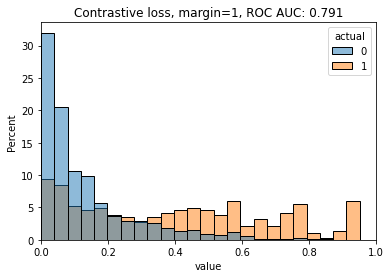

In [ ]:
from keras.models import load_model
import seaborn as sns
from sklearn import metrics

pd.options.display.float_format = '{:.2f}'.format

model = load_model(models_folder + 'mixed_val_loss_shared_weights_CNN_contrastiveloss_euclidean_margin1.hdf5', custom_objects={'PositionEmbedding': PositionEmbedding, 'contrastive_loss': loss})

preds_val = pd.DataFrame(model.predict([validation_data_names, validation_data_nicknames]), columns = ['value'])
preds_val['actual'] = validation_targets

fpr, tpr, thresholds = metrics.roc_curve(preds_val['actual'].values, 
                                         preds_val['value'].values)
print(metrics.auc(fpr, tpr))

sns.histplot(x = 'value', hue = 'actual', data = preds_val, stat="percent", common_norm=False)
plt.title(f'Contrastive loss, margin=1, ROC AUC: {np.round(metrics.auc(fpr, tpr),3)}')
plt.xlim(0,1)


# Merge all Plots

45/45 [==============================] - 1s 7ms/step


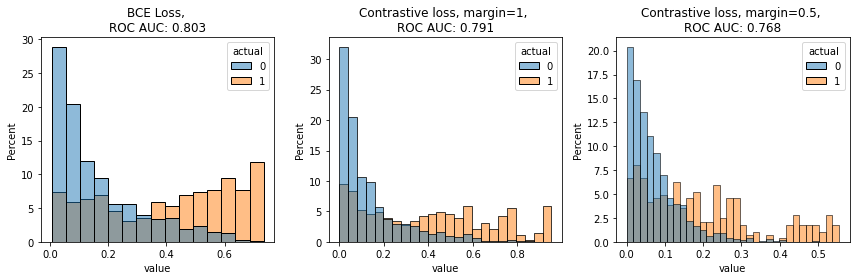

In [ ]:
from keras.models import load_model
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
fig,axs =  plt.subplots(1,3, figsize=(12,4))

# x = np.arange(1,5)
# a[0][0].plot(x,x*x)
# a[0][0].set_title('square')
# a[0][1].plot(x,np.sqrt(x))
# a[0][1].set_title('square root')
# a[1][0].plot(x,np.exp(x))
# a[1][0].set_title('exp')
# a[1][1].plot(x,np.log10(x))
# a[1][1].set_title('log')
# plt.show()

# BCE:
model = load_model(models_folder + 'mixed_val_loss_shared_weights_CNN.hdf5', custom_objects={'PositionEmbedding': PositionEmbedding})

preds_val = pd.DataFrame(model.predict([validation_data_names, validation_data_nicknames]), columns = ['value'])
preds_val['actual'] = validation_targets

fpr, tpr, thresholds = metrics.roc_curve(preds_val['actual'].values, 
                                         preds_val['value'].values)

sns.histplot(ax=axs[0], x = 'value', hue = 'actual', data = preds_val, stat="percent", common_norm=False)
# axs[0].xlim(0,1)
axs[0].set_title(f'BCE Loss, \nROC AUC: {np.round(metrics.auc(fpr, tpr),3)}')


# Contrastive, margin = 1
model = load_model(models_folder + 'mixed_val_loss_shared_weights_CNN_contrastiveloss_euclidean_margin1.hdf5', custom_objects={'PositionEmbedding': PositionEmbedding, 'contrastive_loss': loss})

preds_val = pd.DataFrame(model.predict([validation_data_names, validation_data_nicknames]), columns = ['value'])
preds_val['actual'] = validation_targets

fpr, tpr, thresholds = metrics.roc_curve(preds_val['actual'].values, 
                                         preds_val['value'].values)

sns.histplot(ax=axs[1],x = 'value', hue = 'actual', data = preds_val, stat="percent", common_norm=False)
axs[1].set_title(f'Contrastive loss, margin=1, \nROC AUC: {np.round(metrics.auc(fpr, tpr),3)}')
# axs[1].xlim(0,1)

# Contrastive, margin = 0.5
model = load_model(models_folder + 'mixed_val_loss_shared_weights_CNN_contrastiveloss_euclidean.hdf5', custom_objects={'PositionEmbedding': PositionEmbedding, 'contrastive_loss': loss})
preds_val = pd.DataFrame(model.predict([validation_data_names, validation_data_nicknames]), columns = ['value'])
preds_val['actual'] = validation_targets
fpr, tpr, thresholds = metrics.roc_curve(preds_val['actual'].values, 
                                         preds_val['value'].values)

sns.histplot(ax=axs[2],x = 'value', hue = 'actual', data = preds_val, stat="percent", common_norm=False)
# axs[1].xlim(0,1)
axs[2].set_title(f'Contrastive loss, margin=0.5, \nROC AUC: {np.round(metrics.auc(fpr, tpr),3)}')




fig.tight_layout()
plt.show()